# RESULTS Poker DVS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tonic, torch, os
from hots.network import network
from hots.utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, online_accuracy
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

device = 'cpu'
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/' #-> default if not mentionned

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
trainloader = get_loader(trainset)
testloader = get_loader(testset)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 48
number of samples in the testing set: 20


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-06-10'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path = record_path, device = device)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False, record_path = record_path, device = device)

initial_name_nohomeo = hots_nohomeo.name

## Unsupervised clustering (Figure 4)

In [5]:
if not os.path.exists(hots.record_path):
    os.mkdir(hots.record_path)
    os.mkdir(hots.record_path+'networks/')
path = hots.record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, device = device)
path_nohomeo = hots.record_path+'networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, device = device)

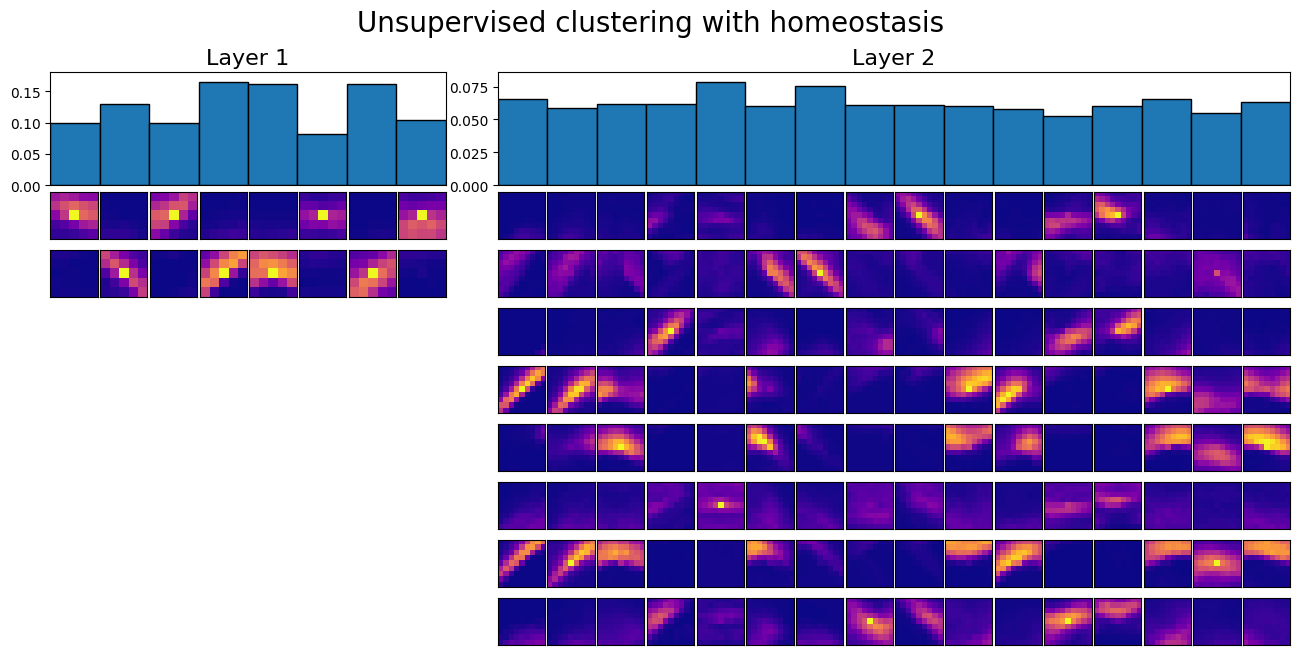

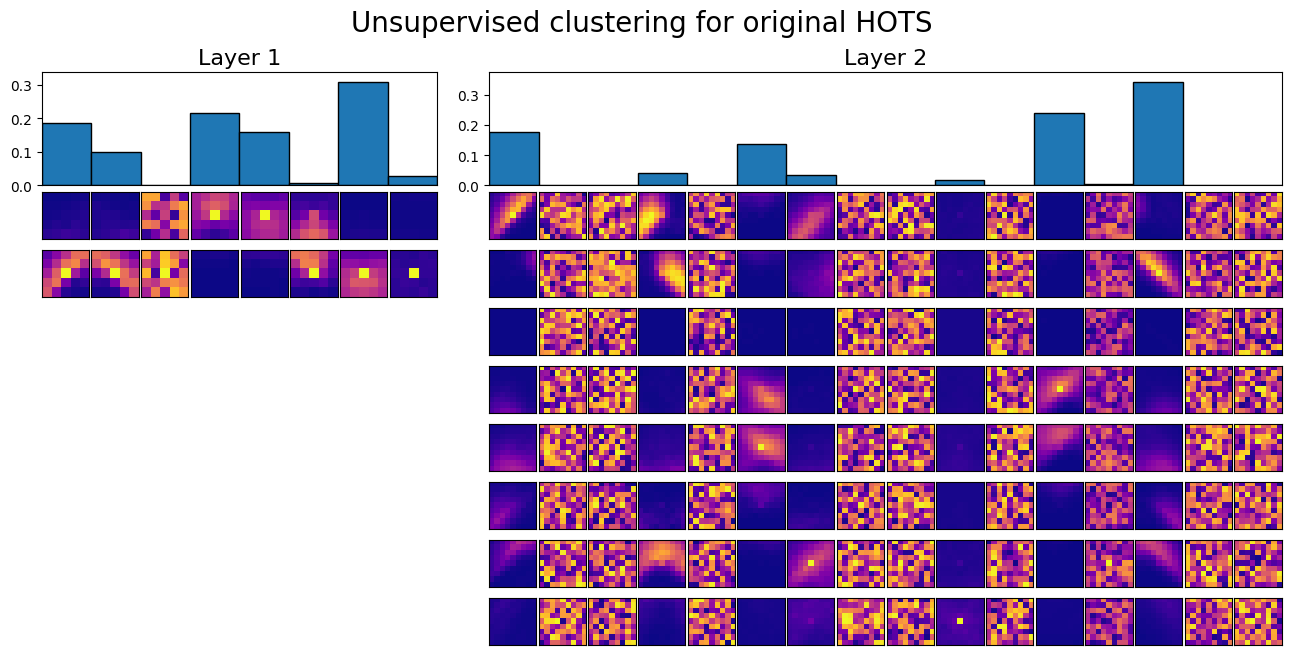

In [6]:
hots.plotlayers();
hots_nohomeo.plotlayers();

## Training of the classification layer

In [7]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 3e4

train_path = f'{hots.record_path}output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'{hots.record_path}output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'{hots.record_path}networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'{hots.record_path}LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device=device, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device, verbose=False)

train_path_nohomeo = f'{hots.record_path}output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'{hots.record_path}output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, device=device, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

## Online Inference (Figure 5-(a))

In [8]:
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])

Number of chance decisions: 0
90th quantile for number of events: 4515.700000000001
Mean accuracy: 97.1%
Last accuracy: 100.0%
Highest probability accuracy: 100.0%


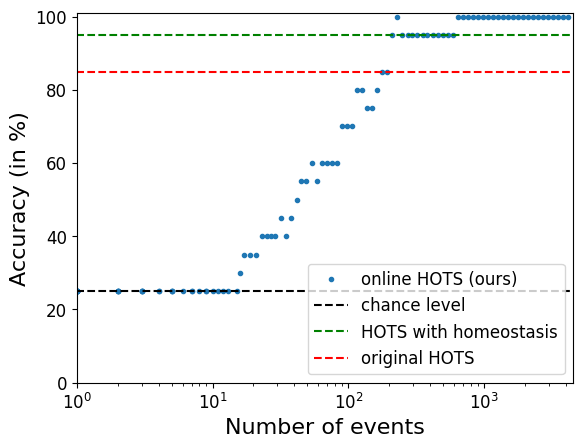

In [9]:
mlr_threshold = None
onlinac,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, online_plot=True)

Number of chance decisions: 0
90th quantile for number of events: 4515.700000000001
Mean accuracy: 100.0%
Last accuracy: 100.0%
Highest probability accuracy: 100.0%


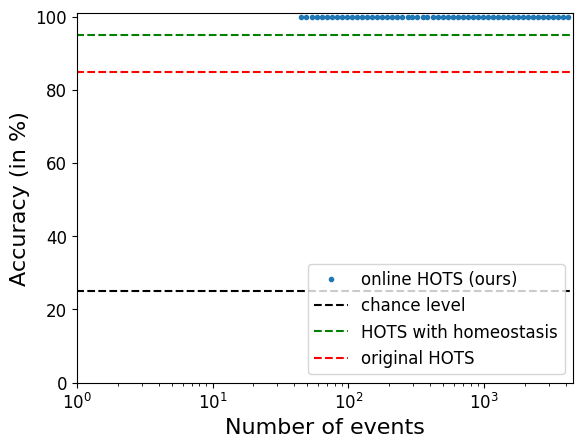

In [10]:
mlr_threshold = .9
onlinac_thres,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, online_plot=True)

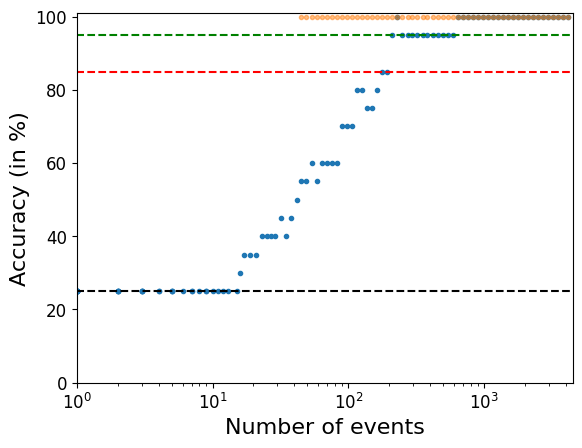

In [11]:
import matplotlib.pyplot as plt

event_90th = 4515
sampling = (np.logspace(0,np.log10(event_90th),100)).astype(int)

fig, ax = plt.subplots()
ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
ax.semilogx(sampling[:-1],onlinac_thres[sampling[:-1]]*100, '.', label='online HOTS \nwith threshold', alpha = .5);
ax.hlines(1/n_classes*100,0,event_90th, linestyles='dashed', color='k', label='chance level')
ax.hlines(score_nohomeo*100,0,event_90th, linestyles='dashed', color='r', label='original HOTS')
ax.hlines(score*100,0,event_90th, linestyles='dashed', color='g', label='HOTS with homeostasis')
ax.set_xlabel('Number of events', fontsize=16);
ax.axis([1,event_90th,0,101]);
#plt.title('LR classification results evolution as a function of the number of events');
plt.setp(ax.get_xticklabels(),fontsize=12)
#ax.set_yticks([])
plt.setp(ax.get_yticklabels(),fontsize=12)
#ax.legend(fontsize=12, loc='lower right');
ax.set_ylabel('Accuracy (in %)', fontsize=16);
    #printfig(fig, figure_name)

## Robustness to spatial jitter (Figure 6-(a)-(up))

In [ ]:
figname = 'spatial_jitter_poker.pdf'
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, mlr_threshold = mlr_threshold, device = device, verbose=True, figure_name = figname);

## Robustness to temporal jitter (Figure 6-(a)-(down))

In [ ]:
figname = 'temporal_jitter_poker.pdf'
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, mlr_threshold = mlr_threshold, device = device, verbose=True, figure_name = figname);

In [42]:
results = np.load('../Records/jitter_results/2022-06-10_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_10_0_10_None_20.npz')

In [43]:
jitter_values = results['arr_0']
scores_jit = results['arr_1']
scores_jit_histo = results['arr_2']
scores_jit_histo_nohomeo = results['arr_3']

In [44]:
fitting = True
logscale = False
jitter_type = 'spatial'
#jitter_values*=1e-3

semi saturation level for online HOTS (ours): [] ms
semi saturation level for HOTS with homeostasis: [] ms
semi saturation level for original HOTS: [] ms


/home/antoine/homhots/hotsline/hots/utils.py:630: RuntimeWarning: divide by zero encountered in power
  x = jitter**powa
/home/antoine/homhots/hotsline/hots/utils.py:630: RuntimeWarning: overflow encountered in power
  x = jitter**powa
/home/antoine/homhots/hotsline/hots/utils.py:631: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:632: RuntimeWarning: invalid value encountered in divide
  output = Rmax-Rmax*x/(x+jitter0)+Rmin
/home/antoine/homhots/hotsline/hots/utils.py:631: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/tmp/ipykernel_355922/3240451774.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_t.set_yticklabels(['']*10);


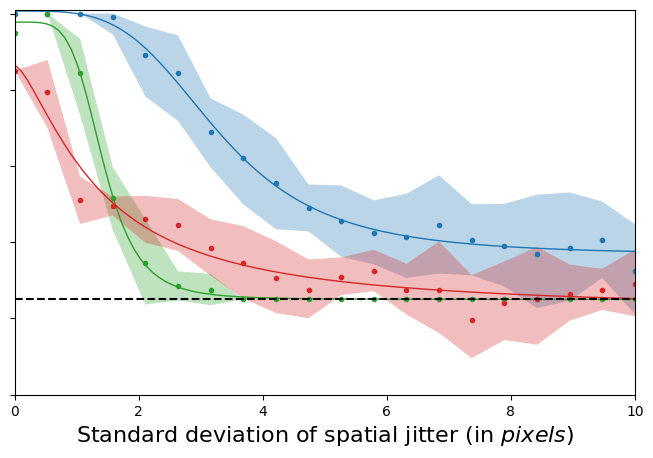

In [49]:
from hots.utils import plotjitter
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))
colorz = ['#2ca02c','#1f77b4','#d62728']
label = 'online HOTS (ours)'
param_T = [.9, 1/n_classes, 3, 20] # to change to adjust the fit
n_epoch = 33

fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit, param = param_T, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'HOTS with homeostasis'
param_T = [.95, 1/n_classes, 2, .1] # to change to adjust the fit
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit_histo, param = param_T, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'original HOTS'
param_T = [.95,1/n_classes, 2, 2] # to change to adjust the fit
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit_histo_nohomeo, param = param_T, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

chance_t = np.ones([len(jitter_values)])*100/n_classes
ax_t.plot(jitter_values,chance_t, 'k--', label='chance level')
if jitter_type=='temporal':
    ax_t.axis([1,max(jitter_values),0,101]);
    ax_t.set_xlabel('Standard deviation of temporal jitter (in $ms$)', fontsize=16);
else:
    ax_t.axis([0,max(jitter_values),0,101]);
    ax_t.set_xlabel('Standard deviation of spatial jitter (in $pixels$)', fontsize=16);
#fig_t.legend(loc='upper right');
#ax_t.set_ylabel('Accuracy (in %)', fontsize=16);
ax_t.set_yticklabels(['']*10);

In [41]:
name = 'temporal_jitter_poker.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig_t.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

In [8]:
import torch
a = torch.randint(0,10,[100])
print(a)
print(torch.where(a>5)[0])

tensor([0, 1, 4, 9, 7, 8, 8, 0, 5, 7, 3, 6, 8, 7, 0, 2, 6, 7, 0, 3, 8, 5, 5, 4,
        7, 5, 6, 0, 5, 9, 2, 9, 4, 7, 0, 9, 1, 2, 2, 2, 6, 1, 2, 9, 1, 9, 3, 7,
        6, 8, 2, 9, 0, 6, 7, 6, 0, 3, 2, 9, 4, 9, 8, 8, 4, 9, 5, 7, 8, 8, 9, 8,
        3, 3, 4, 0, 5, 5, 6, 6, 8, 2, 5, 0, 3, 0, 3, 7, 8, 5, 1, 2, 1, 1, 5, 0,
        0, 2, 8, 7])
tensor([ 3,  4,  5,  6,  9, 11, 12, 13, 16, 17, 20, 24, 26, 29, 31, 33, 35, 40,
        43, 45, 47, 48, 49, 51, 53, 54, 55, 59, 61, 62, 63, 65, 67, 68, 69, 70,
        71, 78, 79, 80, 87, 88, 98, 99])
